In [1]:
import torch
import torch.nn.functional as F
import torch.multiprocessing as mp
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel
from torch.utils.tensorboard import SummaryWriter
import pytorch_lightning as pl
import random
import dotenv
import omegaconf
import hydra
import logging
import wandb
from datetime import date
import dotenv
import os
import pathlib
from typing import Dict, Any
from copy import deepcopy

from rigl_torch.models import ModelFactory
from rigl_torch.rigl_scheduler import RigLScheduler
from rigl_torch.rigl_constant_fan import RigLConstFanScheduler
from rigl_torch.datasets import get_dataloaders
from rigl_torch.optim import (
    get_optimizer,
    get_lr_scheduler,
)
from rigl_torch.utils.checkpoint import Checkpoint
from rigl_torch.utils.rigl_utils import get_T_end, get_fan_in_after_ablation, get_conv_idx_from_flat_idx
from hydra import initialize, compose



In [2]:
with initialize("../configs", version_base="1.2.0"):
    cfg = compose(
        "config.yaml",
        overrides=[
            "dataset=imagenet",
            "compute.distributed=False",
            "model=resnet50"
            ])
dotenv.load_dotenv("../.env")
os.environ["IMAGE_NET_PATH"]
print(cfg.model.name)


resnet50


In [3]:
run_id = "stmf1orh" 
rank=0
checkpoint = Checkpoint.load_last_checkpoint(run_id=run_id, parent_dir = cfg.paths.checkpoints)
# print(checkpoint)
if checkpoint is not None:
    run_id = checkpoint.run_id
    optimizer_state = checkpoint.optimizer
    scheduler_state = checkpoint.scheduler
    pruner_state = checkpoint.pruner
    model_state = checkpoint.model
    cfg = checkpoint.cfg
else:
    run_id, optimizer_state, scheduler_state, pruner_state, model_state = (
        None,
        None,
        None,
        None,
        None,
    )

print(cfg.compute)
cfg.compute.distributed=False
    
pl.seed_everything(cfg.training.seed)
use_cuda = not cfg.compute.no_cuda and torch.cuda.is_available()
if not use_cuda:
    raise SystemError("GPU has stopped responding...waiting to die!")
    logger.warning(
        "Using CPU! Verify cfg.compute.no_cuda and "
        "torch.cuda.is_available() are properly set if this is unexpected"
    )

if cfg.compute.distributed and use_cuda:
    device = torch.device(f"cuda:{rank}")
else:
    print(f"loading to device rank: {rank}")
    device = torch.device(f"cuda:{rank}")
if not use_cuda:
    device = torch.device("cuda" if use_cuda else "cpu")
# train_loader, test_loader = get_dataloaders(cfg)

model = ModelFactory.load_model(
    model=cfg.model.name, dataset=cfg.dataset.name
)
model.to(device)
if cfg.compute.distributed:
    model = DistributedDataParallel(model, device_ids=[rank])
if model_state is not None:
    try:
        model.load_state_dict(model_state)
    except RuntimeError:
        model_state = checkpoint.get_single_process_model_state_from_distributed_state()
        model.load_state_dict(model_state)
        
optimizer = get_optimizer(cfg, model, state_dict=optimizer_state)
scheduler = get_lr_scheduler(cfg, optimizer, state_dict=scheduler_state)
pruner = None
if cfg.rigl.dense_allocation is not None:
    T_end = get_T_end(cfg, [0 for _ in range(0,1251)])
    if cfg.rigl.const_fan_in:
        rigl_scheduler = RigLConstFanScheduler
    else:
        rigl_scheduler = RigLScheduler
    pruner = rigl_scheduler(
        model,
        optimizer,
        dense_allocation=cfg.rigl.dense_allocation,
        alpha=cfg.rigl.alpha,
        delta=cfg.rigl.delta,
        static_topo=cfg.rigl.static_topo,
        T_end=T_end,
        ignore_linear_layers=cfg.rigl.ignore_linear_layers,
        grad_accumulation_n=cfg.rigl.grad_accumulation_n,
        sparsity_distribution=cfg.rigl.sparsity_distribution,
        erk_power_scale=cfg.rigl.erk_power_scale,
        state_dict=pruner_state,
        filter_ablation_threshold=cfg.rigl.filter_ablation_threshold,
        static_ablation=cfg.rigl.static_ablation,
        dynamic_ablation=cfg.rigl.dynamic_ablation,
        min_salient_weights_per_neuron=cfg.rigl.min_salient_weights_per_neuron,  # noqa
        use_sparse_init=cfg.rigl.use_sparse_initialization,
        init_method_str=cfg.rigl.init_method_str,
        use_sparse_const_fan_in_for_ablation=cfg.rigl.use_sparse_const_fan_in_for_ablation,  # noqa
    )
    
    step=0
    
def reinit_ablated_neuron_count(pruner: RigLConstFanScheduler) -> RigLConstFanScheduler:
    pruner.dynamically_ablated_neuron_idx = [
            [x for x in list(range(len(layer))) if x not in layer]
            for layer in pruner.active_neurons
        ]
    return pruner

    
    # checkpoint = Checkpoint(
    #             run_id=run_id,
    #             cfg=cfg,
    #             model=model,
    #             optimizer=optimizer,
    #             scheduler=scheduler,
    #             pruner=pruner,
    #             epoch=0,
    #             step=step,
    #             parent_dir=cfg.paths.checkpoints,
    #         )

    

INFO:rigl_torch.utils.checkpoint:Loading checkpoint from /home/user/condensed-sparsity/artifacts/checkpoints/20230116_stmf1orh/checkpoint.pt.tar...
Global seed set to 42
INFO:/home/user/condensed-sparsity/src/rigl_torch/models/model_factory.py:Loading model resnet50/imagenet using <function get_imagenet_resnet50 at 0x7fe174742a70> with args: () and kwargs: {}


{'no_cuda': False, 'cuda_kwargs': {'num_workers': '${ oc.decode:${oc.env:NUM_WORKERS} }', 'pin_memory': True}, 'distributed': True, 'world_size': 4, 'dist_backend': 'nccl'}
loading to device rank: 0


In [11]:
old_state_dict_keys =['dense_allocation', 'S', 'N', 'delta_T', 'alpha', 'T_end', 'ignore_linear_layers', 'static_topo', 'sparsity_distribution', 'grad_accumulation_n', 'erk_power_scale', 'static_ablation', 'dynamic_ablation', 'min_salient_weights_per_neuron', 'step', 'rigl_steps', 'backward_masks', '_linear_layers_mask', 'itop_rs', 'explored_params', 'active_neurons', 'static_ablated_filters']

In [10]:
self = pruner
obj = {
    "dense_allocation": self.dense_allocation,
    "S": self.S,
    "N": self.N,
    "delta_T": self.delta_T,
    "alpha": self.alpha,
    "T_end": self.T_end,
    "ignore_linear_layers": self.ignore_linear_layers,
    "static_topo": self.static_topo,
    "sparsity_distribution": self.sparsity_distribution,
    "grad_accumulation_n": self.grad_accumulation_n,
    "erk_power_scale": self.erk_power_scale,
    "static_ablation": self.static_ablation,
    "dynamic_ablation": self.dynamic_ablation,
    "min_salient_weights_per_neuron": self.min_salient_weights_per_neuron,  # noqa
    "step": self.step,
    "rigl_steps": self.rigl_steps,
    "backward_masks": self.backward_masks,
    "_linear_layers_mask": self._linear_layers_mask,
    "itop_rs": self.itop_rs,
    "explored_params": self.explored_params,
    "active_neurons": self.active_neurons,
    "static_ablated_filters": self.static_ablated_filters,
}
obj.keys()

dict_keys(['dense_allocation', 'S', 'N', 'delta_T', 'alpha', 'T_end', 'ignore_linear_layers', 'static_topo', 'sparsity_distribution', 'grad_accumulation_n', 'erk_power_scale', 'static_ablation', 'dynamic_ablation', 'min_salient_weights_per_neuron', 'step', 'rigl_steps', 'backward_masks', '_linear_layers_mask', 'itop_rs', 'explored_params', 'active_neurons', 'static_ablated_filters'])

In [57]:
checkpoint.pruner.keys()

dict_keys(['dense_allocation', 'S', 'N', 'delta_T', 'alpha', 'T_end', 'ignore_linear_layers', 'static_topo', 'sparsity_distribution', 'grad_accumulation_n', 'erk_power_scale', 'static_ablation', 'dynamic_ablation', 'min_salient_weights_per_neuron', 'step', 'rigl_steps', 'backward_masks', '_linear_layers_mask', 'itop_rs', 'explored_params', 'active_neurons', 'static_ablated_filters'])

In [56]:
pruner.dynamically_ablated_neuron_idx

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []]

In [54]:
pruner = reinit_ablated_neuron_count(pruner)
# pruner.dynamically_ablated_neuron_idx

In [53]:
def reinit_ablated_neuron_count(pruner: RigLConstFanScheduler) -> RigLConstFanScheduler:
    pruner.dynamically_ablated_neuron_idx=dynamically_ablated_neurons = [ [x for x in list(range(len(layer))) if x not in layer] for layer in pruner.active_neurons]
    for layer_idx, layer in enumerate(pruner.dynamically_ablated_neuron_idx):
        for neuron_idx in layer:
            assert not pruner.backward_masks[layer_idx][neuron_idx].any()
            assert (pruner.W[layer_idx][neuron_idx]==0).all()
    return pruner



In [31]:
for x in dynamically_ablated_neurons[0]:
    if x in pruner.active_neurons[0]:
        print("uhoh")

In [39]:
pruner.active_neurons[3]

[2,
 4,
 6,
 7,
 8,
 10,
 12,
 13,
 16,
 17,
 20,
 21,
 22,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 34,
 35,
 36,
 39,
 41,
 44,
 45,
 46,
 57,
 58,
 59,
 61]

In [28]:
[ [x for x in list(range(len(layer))) if x not in layer] for layer in pruner.active_neurons]

[[0, 1, 2, 3, 4, 5, 6, 8, 9, 12, 13, 18, 19, 20, 22, 23, 25, 30],
 [0, 1, 3, 5, 6, 7, 8, 10, 15, 19, 21, 22, 23, 24, 25, 26],
 [0, 2, 3, 4, 6, 8, 12, 14, 17, 18, 20, 21, 22, 23, 25, 28, 30, 34],
 [0, 1, 3, 5, 9, 11, 14, 15, 18, 19, 23, 32],
 [0, 2, 4, 6, 8, 9, 10, 12, 14, 15, 18, 21, 23, 27, 28, 29, 30],
 [0,
  2,
  6,
  8,
  10,
  13,
  15,
  21,
  23,
  24,
  25,
  26,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  40,
  42,
  43,
  45,
  46,
  47,
  48,
  49,
  51,
  55,
  56,
  57,
  58],
 [1,
  3,
  5,
  7,
  8,
  9,
  10,
  11,
  16,
  17,
  22,
  24,
  28,
  31,
  34,
  36,
  39,
  41,
  51,
  52,
  54,
  56,
  57,
  58,
  60,
  62,
  67,
  68,
  69,
  73],
 [1,
  3,
  5,
  7,
  8,
  9,
  10,
  11,
  16,
  17,
  22,
  24,
  28,
  31,
  34,
  36,
  38,
  39,
  41,
  42,
  51,
  52,
  54,
  56,
  57,
  58,
  60,
  67,
  68],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  10,
  13,
  14,
  15,
  17,
  22,
  24,
  25,
  28,
  31,
  32,
  35,
  36,
  38,
  41,
  47,
  50,
  51,
 

In [26]:
print(pruner)

RigLScheduler(
layers=21,
nonzero_params=[864/1728, 1624/36864, 1628/36864, 1617/36864, 1610/36864, 2400/73728, 3116/147456, 2325/8192, 3136/147456, 3124/147456, 4704/294912, 6256/589824, 4655/32768, 6272/589824, 6300/589824, 9292/1179648, 12420/2359296, 9360/131072, 12506/2359296, 12444/2359296, 5120/5120],
nonzero_percentages=[50.00%, 4.41%, 4.42%, 4.39%, 4.37%, 3.26%, 2.11%, 28.38%, 2.13%, 2.12%, 1.60%, 1.06%, 14.21%, 1.06%, 1.07%, 0.79%, 0.53%, 7.14%, 0.53%, 0.53%, 100.00%],
total_nonzero_params=110773/11164352 (0.99%),
total_CONV_nonzero_params=105653/11159232 (0.95%),
step=97500,
num_rigl_steps=731,
ignoring_linear_layers=False,
sparsity_distribution=erk,
ITOP rate=0.2386,
Active Neuron Count=[(32, 64), (29, 64), (37, 64), (33, 64), (35, 64), (60, 128), (76, 128), (75, 128), (64, 128), (71, 128), (112, 256), (136, 256), (133, 256), (112, 256), (105, 256), (202, 512), (207, 512), (208, 512), (169, 512), (204, 512), (10, 10)],
constant fan ins=[27, 56, 44, 49, 46, 40, 41, 31, 49, 4

In [24]:
# def add_dynamic_ablated_neuron_idx = 


# pruner.dynamically_ablated_neuron_idx  = [[list(range(x)) for x in] for layer_idx, layer in enumerate(pruner.active_neurons)]

In [5]:
pruner.W[0].numel()

9408

In [12]:
torch.count_nonzero(pruner.W[0])

tensor(384, device='cuda:0')

In [7]:
pruner.S[0]

0.9580298609954484

In [6]:
pruner.N[0]

9408

In [11]:
1- pruner.backward_masks[0].sum() / pruner.W[0].numel()

tensor(0.9592, device='cuda:0')

In [14]:
1-384/9408

0.9591836734693877

/home/user/build/.venv/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:124: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "


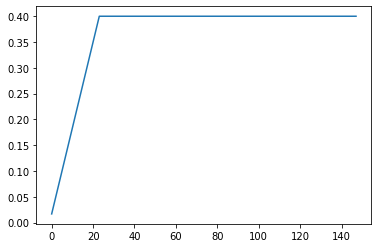

In [4]:
    
import matplotlib.pyplot as plt
%matplotlib inline
lrs=[]
for _ in list(range(1,149)):
    scheduler.step()
    lrs.append(scheduler.get_last_lr())

plt.plot(lrs)

In [5]:
scheduler_state_dict, optimizer_state_dict = checkpoint.get_state()["scheduler"], checkpoint.get_state()["optimizer"]

INFO:rigl_torch.utils.checkpoint:New best checkpoint accuracy (0.000000 > -inf)!


In [6]:
new_optim = get_optimizer(cfg, model, optimizer_state_dict)
ckp_scheduler= get_lr_scheduler(cfg, new_optim, state_dict=scheduler_state_dict)

Loading optimizer from checkpoint...


In [7]:
ckp_scheduler.state_dict()

{'step_size': [150, 350, 450],
 'warm_up_steps': 25,
 'gamma': 0.1,
 'lr': 0.4,
 '_linear_warmup_lrs': array([1.00000000e-06, 1.66676250e-02, 3.33342500e-02, 5.00008750e-02,
        6.66675000e-02, 8.33341250e-02, 1.00000750e-01, 1.16667375e-01,
        1.33334000e-01, 1.50000625e-01, 1.66667250e-01, 1.83333875e-01,
        2.00000500e-01, 2.16667125e-01, 2.33333750e-01, 2.50000375e-01,
        2.66667000e-01, 2.83333625e-01, 3.00000250e-01, 3.16666875e-01,
        3.33333500e-01, 3.50000125e-01, 3.66666750e-01, 3.83333375e-01,
        4.00000000e-01]),
 '_logger': <Logger /home/user/condensed-sparsity/src/rigl_torch/optim/step_lr_with_linear_warm_up.py (INFO)>,
 'base_lrs': [0.4],
 'last_epoch': 148,
 '_step_count': 149,
 'verbose': False,
 '_get_lr_called_within_step': False,
 '_last_lr': [0.4]}

INFO:/home/user/condensed-sparsity/src/rigl_torch/optim/step_lr_with_linear_warm_up.py:Reducing LR to 0.04000000000000001 @ epoch 150
INFO:/home/user/condensed-sparsity/src/rigl_torch/optim/step_lr_with_linear_warm_up.py:Reducing LR to 0.004000000000000001 @ epoch 350
INFO:/home/user/condensed-sparsity/src/rigl_torch/optim/step_lr_with_linear_warm_up.py:Reducing LR to 0.00040000000000000013 @ epoch 450


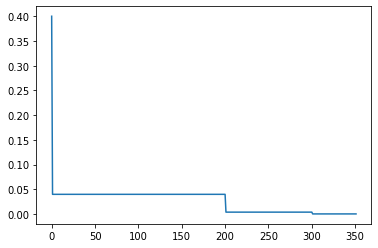

In [9]:
    
import matplotlib.pyplot as plt
%matplotlib inline
lrs=[]
for _ in list(range(149,501)):
    ckp_scheduler.step()
    lrs.append(ckp_scheduler.get_last_lr())

plt.plot(lrs)

In [13]:
ckp_scheduler.__dict__

{'step_size': [150, 350, 450],
 'warm_up_steps': 25,
 'gamma': 0.1,
 'lr': 0.4,
 '_linear_warmup_lrs': array([1.00000000e-06, 1.66676250e-02, 3.33342500e-02, 5.00008750e-02,
        6.66675000e-02, 8.33341250e-02, 1.00000750e-01, 1.16667375e-01,
        1.33334000e-01, 1.50000625e-01, 1.66667250e-01, 1.83333875e-01,
        2.00000500e-01, 2.16667125e-01, 2.33333750e-01, 2.50000375e-01,
        2.66667000e-01, 2.83333625e-01, 3.00000250e-01, 3.16666875e-01,
        3.33333500e-01, 3.50000125e-01, 3.66666750e-01, 3.83333375e-01,
        4.00000000e-01]),
 '_logger': <Logger /home/user/condensed-sparsity/src/rigl_torch/optim/step_lr_with_linear_warm_up.py (INFO)>,
 'optimizer': SGD (
 Parameter Group 0
     dampening: 0
     foreach: None
     initial_lr: 0.4
     lr: 1e-06
     maximize: False
     momentum: 0.9
     nesterov: True
     weight_decay: 0.0001
 ),
 'base_lrs': [0.4],
 'last_epoch': 148,
 '_step_count': 149,
 'verbose': False,
 '_get_lr_called_within_step': False,
 '_last_l

/home/user/build/.venv/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:124: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "
INFO:/home/user/condensed-sparsity/src/rigl_torch/optim/step_lr_with_linear_warm_up.py:Reducing LR to 0.04000000000000001 @ epoch 150
INFO:/home/user/condensed-sparsity/src/rigl_torch/optim/step_lr_with_linear_warm_up.py:Reducing LR to 0.004000000000000001 @ epoch 350
INFO:/home/user/condensed-sparsity/src/rigl_torch/optim/step_lr_with_linear_warm_up.py:Reducing LR to 0.00040000000000000013 @ epoch 450


[[0.016667625000000002], [0.03333425], [0.050000875], [0.0666675], [0.08333412500000001], [0.10000075], [0.116667375], [0.133334], [0.150000625], [0.16666725000000002], [0.183333875], [0.2000005], [0.21666712500000002], [0.23333375], [0.250000375], [0.266667], [0.283333625], [0.30000024999999997], [0.316666875], [0.3333335], [0.350000125], [0.36666675], [0.383333375], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4], [0.4],

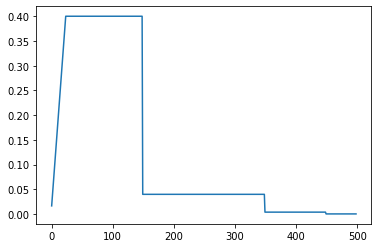

In [17]:
import matplotlib.pyplot as plt

lrs = []
for epoch in list(range(1,150)):
    scheduler.step()
    lrs.append(scheduler.get_last_lr())
print(lrs)
plt.plot(lrs)

In [5]:
pruner.__str__()

'RigLScheduler(\nlayers=54,\nnonzero_params=[384/9408, 576/4096, 640/36864, 1536/16384, 1536/16384, 1536/16384, 640/36864, 1536/16384, 1536/16384, 640/36864, 1536/16384, 1792/32768, 1152/147456, 3072/65536, 3584/131072, 3072/65536, 1152/147456, 3072/65536, 3072/65536, 1152/147456, 3072/65536, 3072/65536, 1152/147456, 3072/65536, 3584/131072, 2304/589824, 6144/262144, 7168/524288, 6144/262144, 2304/589824, 6144/262144, 6144/262144, 2304/589824, 6144/262144, 6144/262144, 2304/589824, 6144/262144, 6144/262144, 2304/589824, 6144/262144, 6144/262144, 2304/589824, 6144/262144, 7168/524288, 4608/2359296, 12288/1048576, 14336/2097152, 12288/1048576, 4608/2359296, 12288/1048576, 12288/1048576, 4608/2359296, 12288/1048576, 14000/2048000],\nnonzero_percentages=[4.08%, 14.06%, 1.74%, 9.38%, 9.38%, 9.38%, 1.74%, 9.38%, 9.38%, 1.74%, 9.38%, 5.47%, 0.78%, 4.69%, 2.73%, 4.69%, 0.78%, 4.69%, 4.69%, 0.78%, 4.69%, 4.69%, 0.78%, 4.69%, 2.73%, 0.39%, 2.34%, 1.37%, 2.34%, 0.39%, 2.34%, 2.34%, 0.39%, 2.34%, 

In [18]:
# net = ModelFactory.load_model("wide_resnet22", "cifar10")
model = ModelFactory.load_model("resnet50", "imagenet")
device = torch.device("cuda:0")
train_loader, test_loader = get_dataloaders(cfg)
# model = ModelFactory.load_model(
#         model=cfg.model.name, dataset=cfg.dataset.name
#     )
model.to(device)
optimizer = get_optimizer(cfg, model, state_dict=None)
scheduler = get_lr_scheduler(cfg, optimizer, state_dict=None)
T_end = get_T_end(cfg, train_loader)
if cfg.rigl.const_fan_in:
    rigl_scheduler = RigLConstFanScheduler
else:
    rigl_scheduler = RigLScheduler
# pruner = rigl_scheduler(
#     model,
#     optimizer,
#     dense_allocation=cfg.rigl.dense_allocation,
#     alpha=cfg.rigl.alpha,
#     delta=cfg.rigl.delta,
#     static_topo=cfg.rigl.static_topo,
#     T_end=T_end,
#     ignore_linear_layers=False,
#     grad_accumulation_n=cfg.rigl.grad_accumulation_n,
#     sparsity_distribution=cfg.rigl.sparsity_distribution,
#     erk_power_scale=cfg.rigl.erk_power_scale,
#     state_dict=None,
#     filter_ablation_threshold=cfg.rigl.filter_ablation_threshold,
#     static_ablation=cfg.rigl.static_ablation,
#     dynamic_ablation=cfg.rigl.dynamic_ablation,
#     min_salient_weights_per_neuron=cfg.rigl.min_salient_weights_per_neuron,
#     )

INFO:/project/6066928/mklasby/condensed-sparsity/src/rigl_torch/models/model_factory.py:Loading model resnet50/imagenet using <function get_imagenet_resnet50 at 0x7f808c85ac10> with args: () and kwargs: {}


Files already downloaded and verified


In [ ]:
pruner(
    
)